In [1]:
#--- loading ---#
library(MouseGastrulationData)
sce.chimera <- WTChimeraData(samples=5:10)
sce.chimera

#--- feature-annotation ---#
library(scater)
rownames(sce.chimera) <- uniquifyFeatureNames(
    rowData(sce.chimera)$ENSEMBL, rowData(sce.chimera)$SYMBOL)

#--- quality-control ---#
drop <- sce.chimera$celltype.mapped %in% c("stripped", "Doublet")
sce.chimera <- sce.chimera[,!drop]

#--- normalization ---#
sce.chimera <- logNormCounts(sce.chimera)

#--- variance-modelling ---#
library(scran)
dec.chimera <- modelGeneVar(sce.chimera, block=sce.chimera$sample)
chosen.hvgs <- dec.chimera$bio > 0

#--- merging ---#
library(batchelor)
set.seed(01001001)
merged <- correctExperiments(sce.chimera, 
    batch=sce.chimera$sample, 
    subset.row=chosen.hvgs,
    PARAM=FastMnnParam(
        merge.order=list(
            list(1,3,5), # WT (3 replicates)
            list(2,4,6)  # td-Tomato (3 replicates)
        )
    )
)

#--- clustering ---#
g <- buildSNNGraph(merged, use.dimred="corrected")
clusters <- igraph::cluster_louvain(g)
colLabels(merged) <- factor(clusters$membership)

#--- dimensionality-reduction ---#
merged <- runTSNE(merged, dimred="corrected", external_neighbors=TRUE)
merged <- runUMAP(merged, dimred="corrected", external_neighbors=TRUE)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

class: SingleCellExperiment 
dim: 29453 20935 
metadata(0):
assays(1): counts
rownames(29453): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000095742 tomato-td
rowData names(2): ENSEMBL SYMBOL
colnames(20935): cell_9769 cell_9770 ... cell_30702 cell_30703
colData names(11): cell barcode ... doub.density sizeFactor
reducedDimNames(2): pca.corrected.E7.5 pca.corrected.E8.5
altExpNames(0):

Loading required package: ggplot2



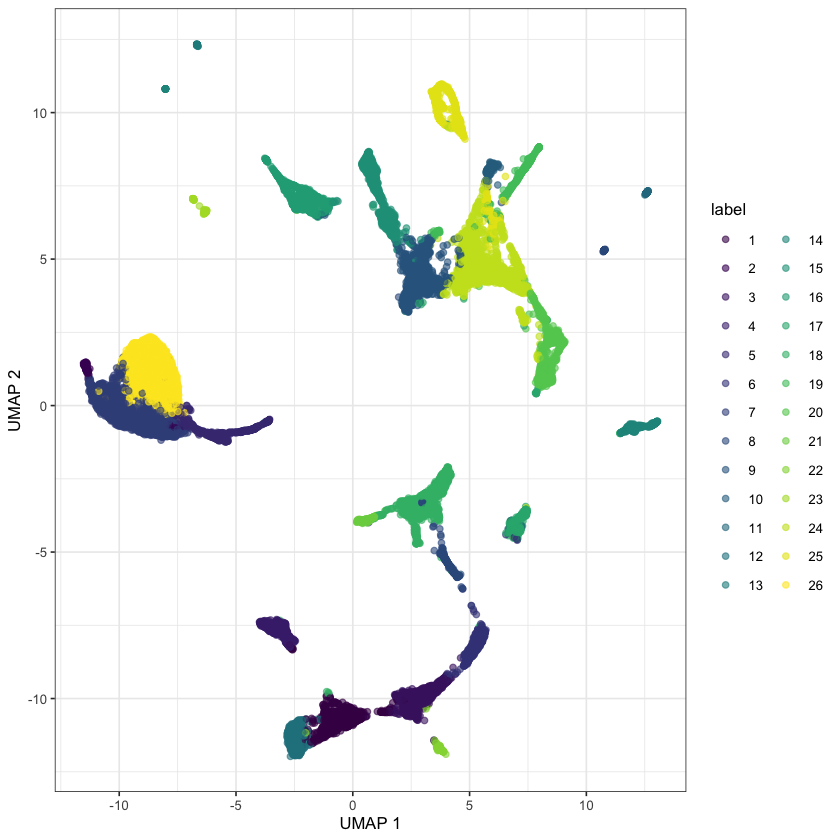

In [7]:
plotUMAP(merged, colour_by="label")

In [6]:
library(scater)
table(colLabels(merged), merged$tomato)

    
     FALSE TRUE
  1    546  401
  2     60   52
  3    470  398
  4    469  211
  5    335  271
  6    258  249
  7   1241  967
  8    203  221
  9    630  629
  10    71  181
  11    47   57
  12   417  310
  13    58    0
  14   209  214
  15   414  630
  16   363  509
  17   234  198
  18   657  607
  19   151  303
  20   579  443
  21   137   74
  22    82   78
  23   155    1
  24   762  878
  25   363  497
  26  1420  716

In [8]:
table(colLabels(merged), merged$pool)

    
        3    4    5
  1   224  173  550
  2    26   30   56
  3   226  172  470
  4    78  162  440
  5    99  227  280
  6   187  116  204
  7   300  909  999
  8    69  134  221
  9   229  423  607
  10  114   54   84
  11   16   31   57
  12  179  169  379
  13    2   51    5
  14   77   97  249
  15  114  289  641
  16  183  242  447
  17  157   81  194
  18  123  308  833
  19  106  118  230
  20  236  238  548
  21    3   10  198
  22   27   29  104
  23    6   84   66
  24  217  455  968
  25  132  172  556
  26  194  870 1072

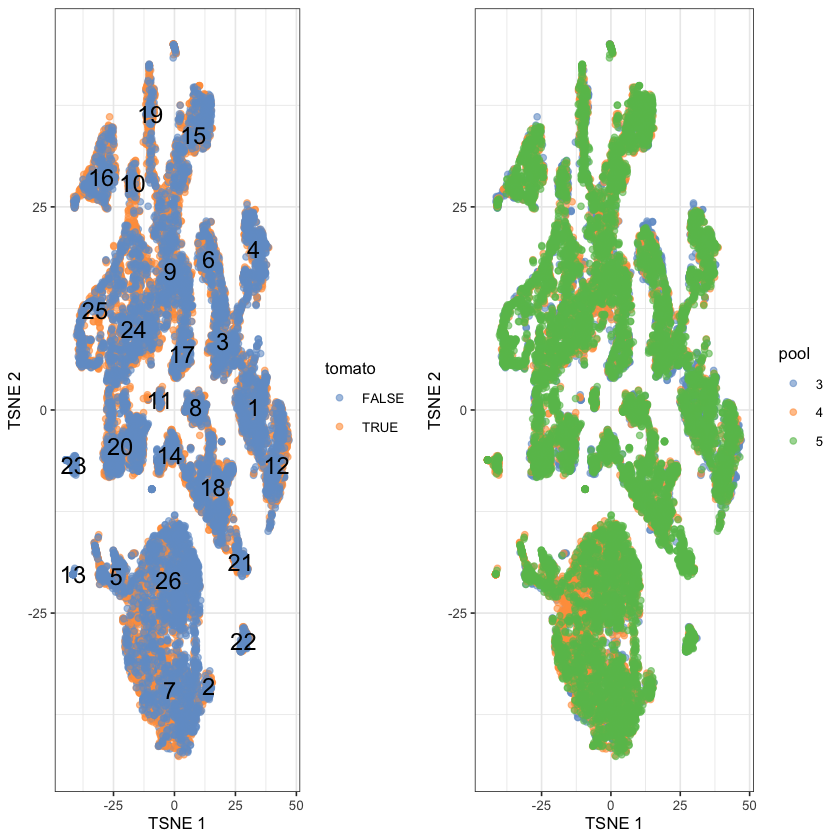

In [9]:
gridExtra::grid.arrange(
    plotTSNE(merged, colour_by="tomato", text_by="label"),
    plotTSNE(merged, colour_by=data.frame(pool=factor(merged$pool))),
    ncol=2
)

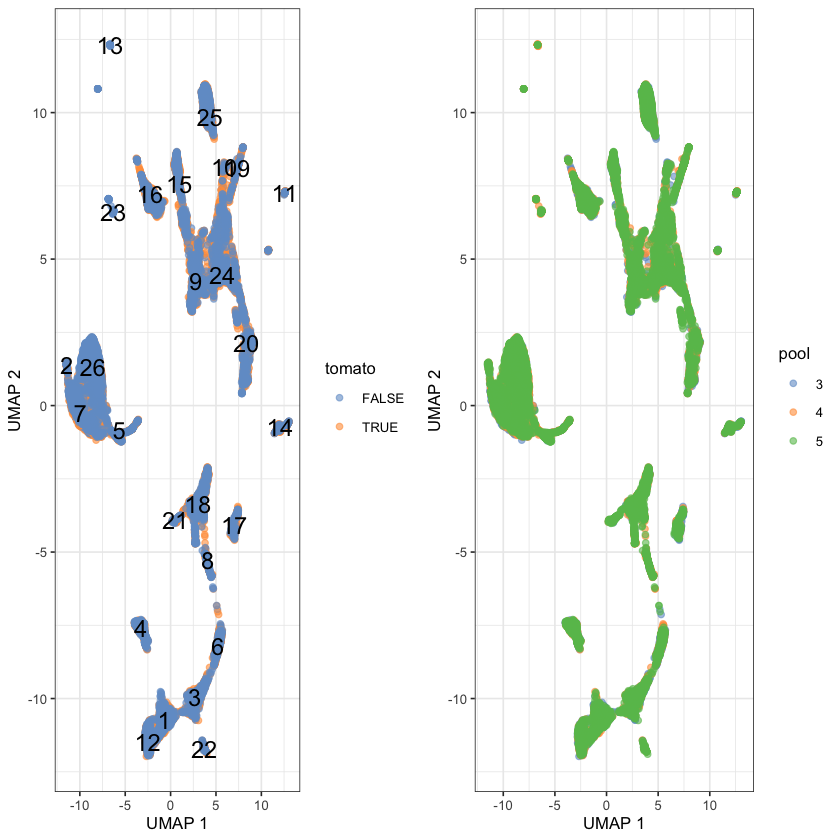

In [10]:
gridExtra::grid.arrange(
    plotUMAP(merged, colour_by="tomato", text_by="label"),
    plotUMAP(merged, colour_by=data.frame(pool=factor(merged$pool))),
    ncol=2
)

In [11]:
library(bluster)
pairwiseRand(colLabels(merged), merged$celltype.mapped, "index")


Attaching package: ‘bluster’


The following objects are masked from ‘package:scran’:

    neighborsToKNNGraph, neighborsToSNNGraph




[1] 0.5513742

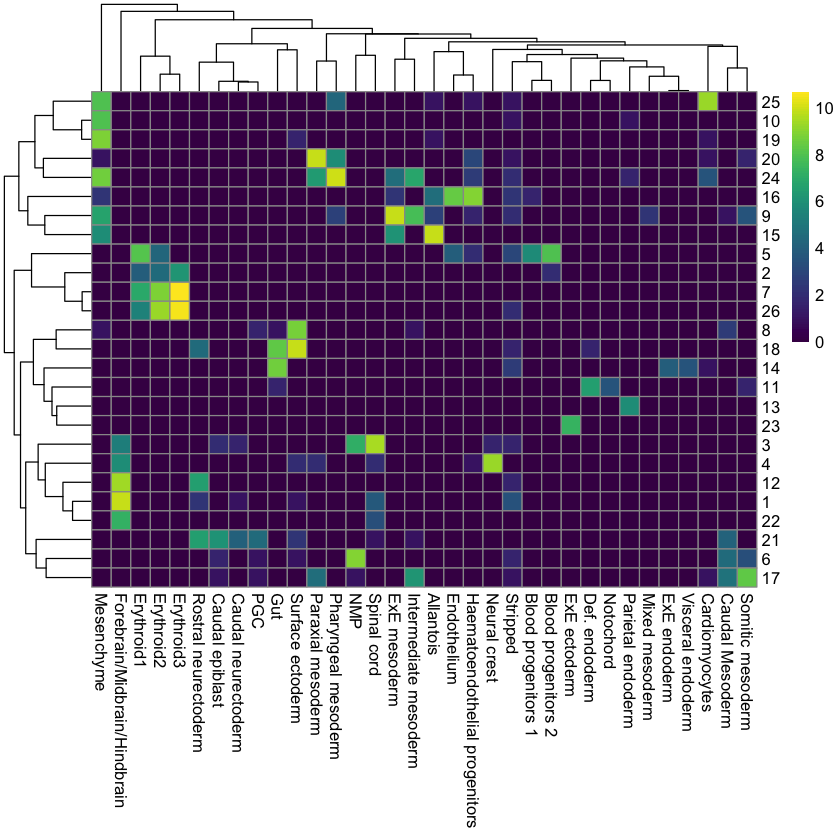

In [13]:
by.label <- table(colLabels(merged), merged$celltype.mapped)
pheatmap::pheatmap(log2(by.label+1), color=viridis::viridis(101))

In [18]:
summed <- aggregateAcrossCells(merged, 
    id=colData(merged)[,c("celltype.mapped", "sample")])
summed

class: SingleCellExperiment 
dim: 14699 186 
metadata(2): merge.info pca.info
assays(1): counts
rownames(14699): Xkr4 Rp1 ... Vmn2r122 CAAA01147332.1
rowData names(3): rotation ENSEMBL SYMBOL
colnames: NULL
colData names(16): batch cell ... sample ncells
reducedDimNames(5): corrected pca.corrected.E7.5 pca.corrected.E8.5
  TSNE UMAP
altExpNames(0):

In [19]:
label <- "Mesenchyme"
current <- summed[,label==summed$celltype.mapped]

# Creating up a DGEList object for use in edgeR:
library(edgeR)
y <- DGEList(counts(current), samples=colData(current))
y

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:scater’:

    plotMDS


The following object is masked from ‘package:BiocGenerics’:

    plotMA



Attaching package: ‘edgeR’


The following object is masked from ‘package:SingleCellExperiment’:

    cpm




,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6
Xkr4,2,0,0,0,3,0
Rp1,0,0,1,0,0,0
Sox17,7,0,3,0,14,9
Mrpl15,1420,271,1009,379,1578,749
Rgs20,3,0,1,1,0,0
Oprk1,15,0,7,1,5,7
Npbwr1,2,1,4,3,10,4
4732440D04Rik,37,4,14,2,16,5
Fam150a,1,0,0,0,0,1
Pcmtd1,139,34,32,25,67,35


In [20]:
discarded <- current$ncells < 10
y <- y[,!discarded]
summary(discarded)

   Mode   FALSE 
logical       6 

In [21]:
keep <- filterByExpr(y, group=current$tomato)
y <- y[keep,]
summary(keep)

   Mode   FALSE    TRUE 
logical    9011    5688 

In [22]:
y <- calcNormFactors(y)
y$samples

,group,lib.size,norm.factors,batch,cell,barcode,sample,stage,tomato,pool,stage.mapped,celltype.mapped,closest.cell,doub.density,sizeFactor,label,celltype.mapped.1,sample.1,ncells
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<lgl>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<int>,<int>
Sample1,1,4607053,1.0683392,5,NA,NA,5,E8.5,TRUE,3,NA,Mesenchyme,NA,NA,NA,NA,Mesenchyme,5,286
Sample2,1,1064970,1.0487418,6,NA,NA,6,E8.5,FALSE,3,NA,Mesenchyme,NA,NA,NA,NA,Mesenchyme,6,55
Sample3,1,2494010,0.9582296,7,NA,NA,7,E8.5,TRUE,4,NA,Mesenchyme,NA,NA,NA,NA,Mesenchyme,7,243
Sample4,1,1028668,0.9774156,8,NA,NA,8,E8.5,FALSE,4,NA,Mesenchyme,NA,NA,NA,NA,Mesenchyme,8,134
Sample5,1,4290221,0.9707300,9,NA,NA,9,E8.5,TRUE,5,NA,Mesenchyme,NA,NA,NA,NA,Mesenchyme,9,478
Sample6,1,1950840,0.9816914,10,NA,NA,10,E8.5,FALSE,5,NA,Mesenchyme,NA,NA,NA,NA,Mesenchyme,10,299


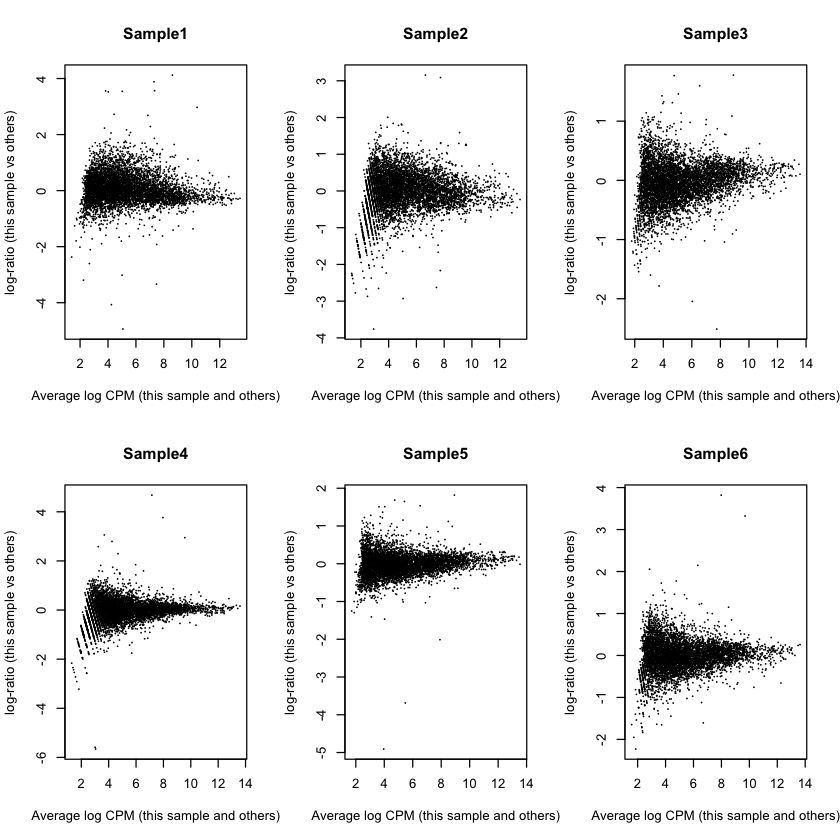

In [23]:
par(mfrow=c(2,3))
for (i in seq_len(ncol(y))) {
    plotMD(y, column=i)
}

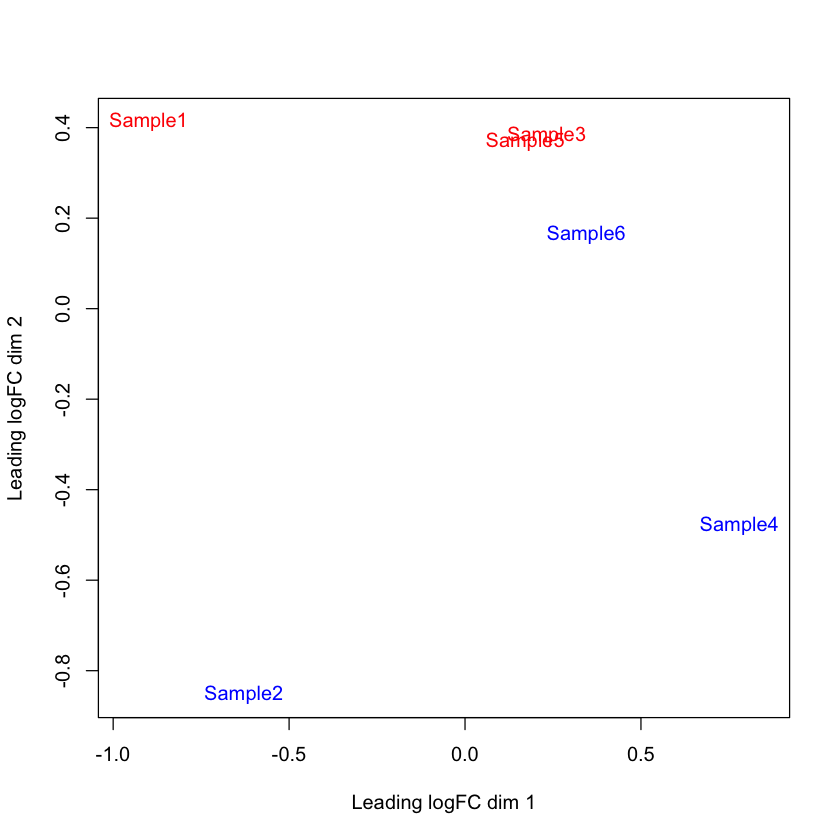

In [24]:
plotMDS(cpm(y, log=TRUE), 
    col=ifelse(y$samples$tomato, "red", "blue"))

In [25]:
design <- model.matrix(~factor(pool) + factor(tomato), y$samples)
design

,(Intercept),factor(pool)4,factor(pool)5,factor(tomato)TRUE
Sample1,1,0,0,1
Sample2,1,0,0,0
Sample3,1,1,0,1
Sample4,1,1,0,0
Sample5,1,0,1,1
Sample6,1,0,1,0


In [26]:
y <- estimateDisp(y, design)
summary(y$trended.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01026 0.01670 0.02128 0.02020 0.02349 0.02665 

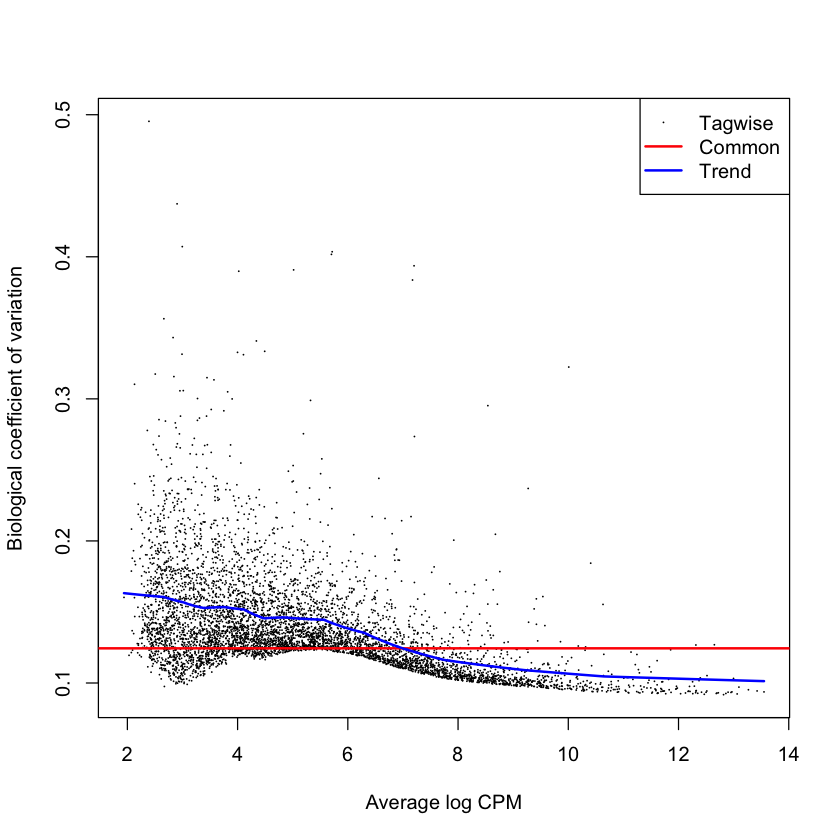

In [27]:
plotBCV(y)

In [28]:
fit <- glmQLFit(y, design, robust=TRUE)
summary(fit$var.prior)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3179  0.7143  0.8538  0.8045  0.9128  1.0665 

In [29]:
summary(fit$df.prior)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2267 12.6749 12.6749 12.3390 12.6749 12.6749 

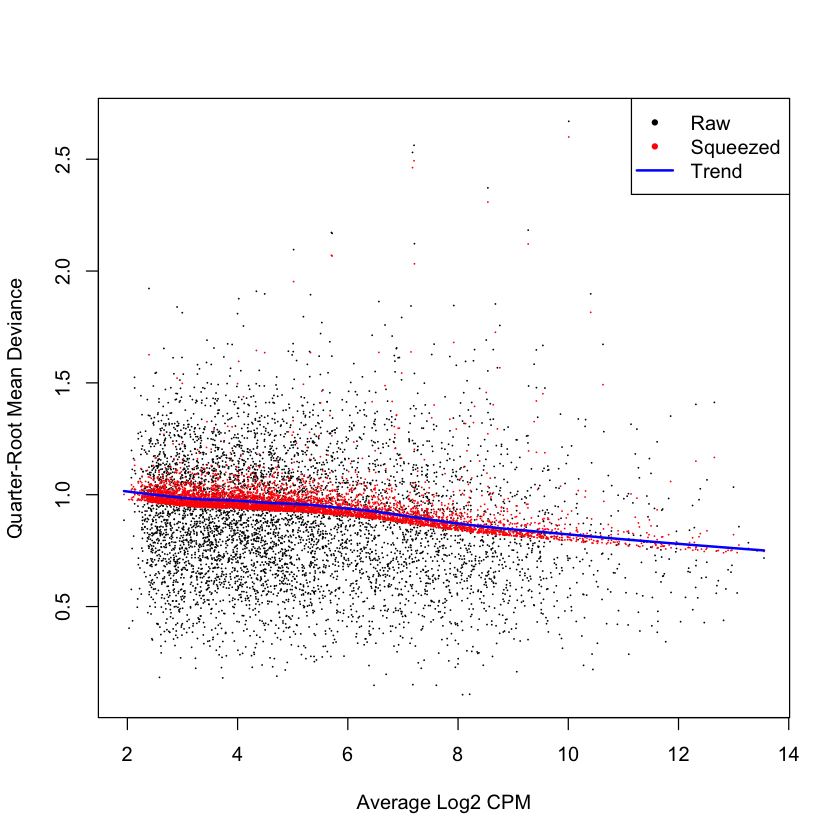

In [30]:
plotQLDisp(fit)

In [31]:
res <- glmQLFTest(fit, coef=ncol(design))
summary(decideTests(res))

       factor(tomato)TRUE
Down                    8
NotSig               5672
Up                      8

In [32]:
topTags(res)


,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Phlda2,-4.3873546,9.934130,1638.59469,1.812293e-16,1.030832e-12
Erdr1,2.0690698,8.832662,356.36590,1.060836e-11,3.017019e-08
Mid1,1.5190728,6.931325,120.14656,1.844351e-08,3.496889e-05
H13,-1.0596020,7.540121,80.79795,2.373001e-07,2.526790e-04
Kcnq1ot1,1.3762700,7.241651,83.30701,2.392052e-07,2.526790e-04
Akr1e1,-1.7205826,5.127802,79.31386,2.665390e-07,2.526790e-04
Zdbf2,1.8008336,6.797367,83.66324,6.808994e-07,5.532794e-04
Asb4,-0.9234911,7.340648,53.44578,2.918297e-06,2.074909e-03
Impact,0.8516300,7.353208,50.31429,4.145416e-06,2.619903e-03


In [33]:
# Removing all pseudo-bulk samples with 'insufficient' cells.
summed.filt <- summed[,summed$ncells >= 10]

library(scran)
de.results <- pseudoBulkDGE(summed.filt, 
    label=summed.filt$celltype.mapped,
    design=~factor(pool) + tomato,
    coef="tomatoTRUE",
    condition=summed.filt$tomato 
)

In [34]:
cur.results <- de.results[["Allantois"]]
cur.results[order(cur.results$PValue),]

DataFrame with 14699 rows and 5 columns
                              logFC    logCPM         F      PValue         FDR
                          <numeric> <numeric> <numeric>   <numeric>   <numeric>
Phlda2                    -2.489508  12.58150  1207.016 3.33486e-21 1.60507e-17
Xist                      -7.978532   8.00166  1092.831 1.27783e-17 3.07510e-14
Erdr1                      1.947170   9.07321   296.937 1.58009e-14 2.53500e-11
Slc22a18                  -4.347153   4.04380   117.389 1.92517e-10 2.31647e-07
Slc38a4                    0.891849  10.24094   113.899 2.52208e-10 2.42776e-07
...                             ...       ...       ...         ...         ...
Ccl27a_ENSMUSG00000095247        NA        NA        NA          NA          NA
CR974586.5                       NA        NA        NA          NA          NA
AC132444.6                       NA        NA        NA          NA          NA
Vmn2r122                         NA        NA        NA          NA          NA


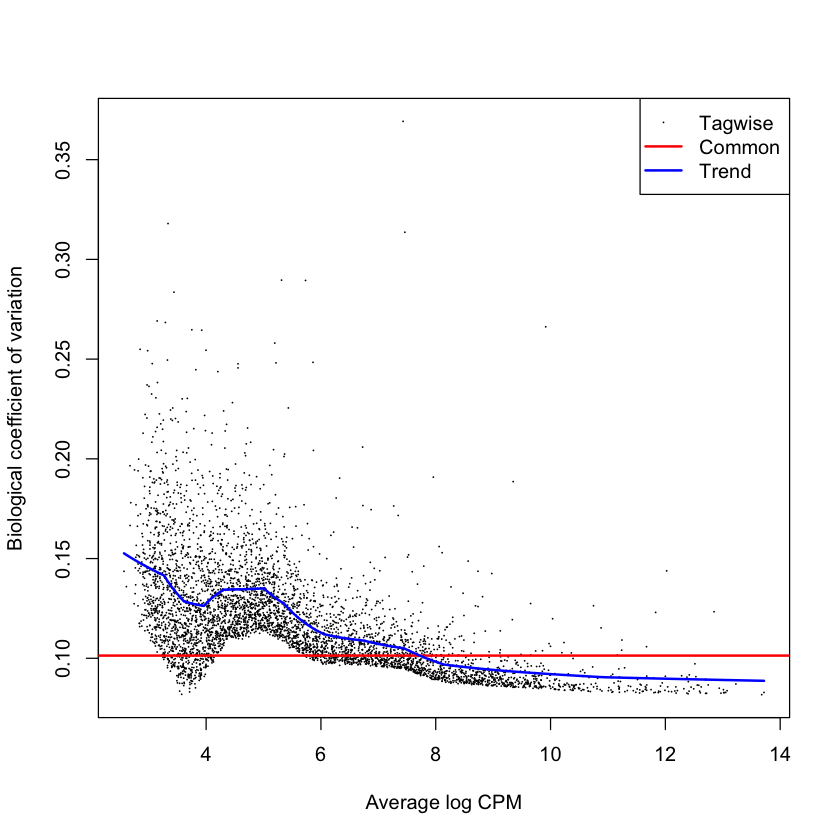

In [35]:
y.allantois <- metadata(cur.results)$y
plotBCV(y.allantois)

In [36]:
metadata(de.results)$failed

[1] "Blood progenitors 1" "Caudal epiblast"     "Caudal neurectoderm"
[4] "ExE ectoderm"        "Parietal endoderm"   "Stripped"

In [37]:
is.de <- decideTestsPerLabel(de.results, threshold=0.05)
summarizeTestsPerLabel(is.de)

,-1,0,1,NA
Allantois,23,4766,24,9886
Blood progenitors 2,1,2472,2,12224
Cardiomyocytes,6,4361,5,10327
Caudal Mesoderm,2,1742,0,12955
Def. endoderm,7,1392,2,13298
Endothelium,3,3222,6,11468
Erythroid1,12,2777,15,11895
Erythroid2,5,3389,8,11297
Erythroid3,13,5048,16,9622
ExE mesoderm,2,5097,10,9590


In [38]:
# Upregulated across most cell types.
up.de <- is.de > 0 & !is.na(is.de)
head(sort(rowMeans(up.de), decreasing=TRUE), 10)

Mid1     Erdr1    Impact     Mcts2  Kcnq1ot1      Nnat   Slc38a4     Zdbf2 
0.9130435 0.7391304 0.6086957 0.5652174 0.5652174 0.5217391 0.4347826 0.3913043 
     Hopx      Peg3 
0.3913043 0.2608696

In [39]:
# Downregulated across cell types.
down.de <- is.de < 0 & !is.na(is.de)
head(sort(rowMeans(down.de), decreasing=TRUE), 10)

Xist        Phlda2        Akr1e1        Cdkn1c           H13 
   0.73913043    0.73913043    0.73913043    0.69565217    0.52173913 
        Wfdc2 B930036N10Rik B230312C02Rik         Pink1         Mfap2 
   0.21739130    0.08695652    0.08695652    0.08695652    0.08695652

In [40]:
de.specific <- pseudoBulkSpecific(summed.filt,
    label=summed.filt$celltype.mapped,
    design=~factor(pool) + tomato,
    coef="tomatoTRUE",
    condition=summed.filt$tomato
)

cur.specific <- de.specific[["Allantois"]]
cur.specific <- cur.specific[order(cur.specific$PValue),]
cur.specific

DataFrame with 14699 rows and 6 columns
                              logFC    logCPM         F      PValue         FDR
                          <numeric> <numeric> <numeric>   <numeric>   <numeric>
Slc22a18                  -4.347153   4.04380  117.3889 1.92517e-10 9.26587e-07
Acta2                     -0.829713   9.12472   55.6350 4.67332e-07 1.12463e-03
Mxd4                      -1.421473   5.64606   50.2112 2.03567e-06 3.26589e-03
Rbp4                       1.874290   4.35449   29.8731 1.53998e-05 1.85298e-02
Myl9                      -0.985541   6.24833   30.6689 5.54072e-05 4.62274e-02
...                             ...       ...       ...         ...         ...
Ccl27a_ENSMUSG00000095247        NA        NA        NA          NA          NA
CR974586.5                       NA        NA        NA          NA          NA
AC132444.6                       NA        NA        NA          NA          NA
Vmn2r122                         NA        NA        NA          NA          NA
